# Inicio

In [136]:
import pandas as pd
import numpy as np
import re
import os
import json
import boto3
from datetime import date
import pickle

import warnings
warnings.filterwarnings("ignore")

# Leer archivo

In [2]:
bucket = "henry-pf"
nyc_co2 = "datos-dashboard/MONTH=5/NYC_CO2/"

In [3]:
s3 = boto3.resource("s3")
s3_client = boto3.client("s3")
bucket = s3.Bucket(bucket)

In [4]:
bucket = "henry-pf"
data = s3_client.list_objects_v2(Bucket=bucket, Prefix=nyc_co2)

In [6]:
obj = s3.Object(bucket, key=data["Contents"][1]["Key"])
obj

s3.Object(bucket_name='henry-pf', key='datos-dashboard/MONTH=5/NYC_CO2/NYC_CO2.csv')

In [ ]:
with open("NYC_CO2.csv", "wb") as file:
    obj.download_fileobj(file)

In [13]:
df = pd.read_csv("NYC_CO2.csv")
df.head()

,Year,Total
0,1970,284.91
1,1971,277.05
2,1972,274.09
3,1973,280.37
4,1974,258.79


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    52 non-null     int64  
 1   Total   52 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 960.0 bytes


In [26]:
df.describe()

,Year,Total
count,52.000000,52.000000
mean,1995.500000,205.111923
std,15.154757,33.478172
min,1970.000000,143.420000
25%,1982.750000,181.807500
50%,1995.500000,199.885000
75%,2008.250000,213.252500
max,2021.000000,284.910000


<Axes: xlabel='Year'>

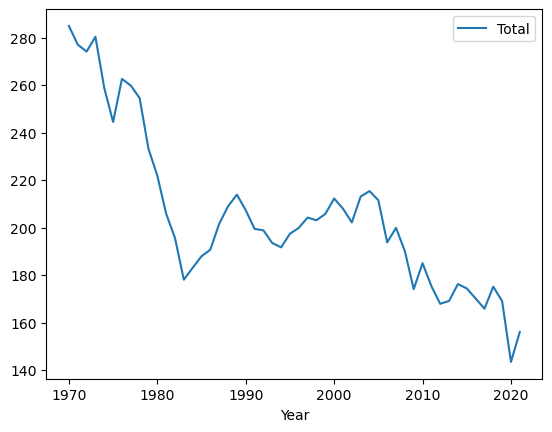

In [27]:
df.plot(x="Year", y="Total")

In [20]:
df_time = df.copy()
df_time.Year = df_time.Year.apply(lambda x: date(year=x, month=1, day=1))
df_time.set_index("Year", inplace=True)
df_time.head()

,Total
Year,
1970-01-01,284.91
1971-01-01,277.05
1972-01-01,274.09
1973-01-01,280.37
1974-01-01,258.79


In [29]:
len_train = len(df)-5

# Entrenamiento y prueba del modelo

In [37]:
import sklearn as skl
import skforecast as skf
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Autocorrelación y autocorrelación parcial

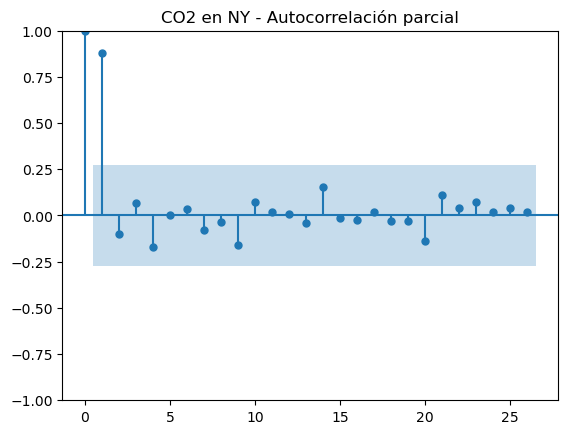

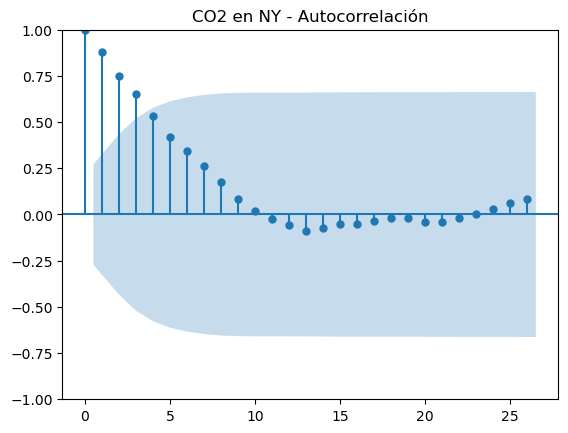

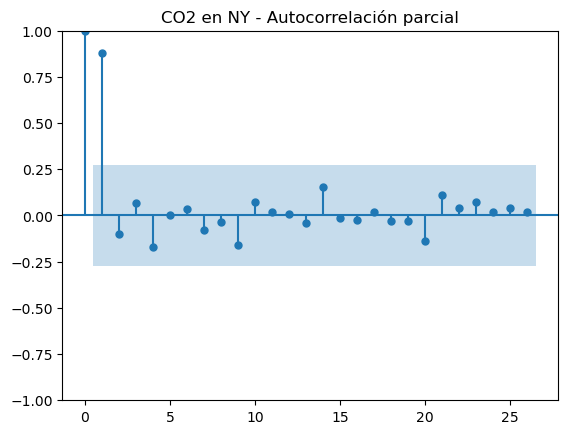

In [44]:
plot_acf(df_time.Total, lags=26, title = "CO2 en NY - Autocorrelación")
plot_pacf(df_time.Total, lags=26, title = "CO2 en NY - Autocorrelación parcial")

## Modelo Ridge

In [45]:
def calcular_u1(y_true, y_pred):
    size = len(y_true)
    u = np.sqrt(np.sum(np.square(y_true-y_pred))/size)
    u /= np.sum(np.sqrt(np.sum(np.square(y_true))/size)+np.sqrt(np.sum(np.square(y_pred))/size))
    return u

In [79]:
lags_grid = [2, 4, 7, 9, 14]
param_grid = {
    "alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0],
    "fit_intercept": [True, False],
    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

forecaster = ForecasterAutoreg(
    regressor=Ridge(random_state=42),
    lags=7
)

grid = grid_search_forecaster(
    forecaster=forecaster,
    y = df.Total,
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=5,
    metric=calcular_u1,
    initial_train_size=len_train,
    refit=True,
    fixed_train_size=True,
    return_best=True,
    verbose=False,
    show_progress=True
)

grid

Number of models compared: 360.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/72 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8 9] 
  Parameters: {'alpha': 0.01, 'fit_intercept': False, 'solver': 'sparse_cg'}
  Backtesting metric: 0.024653989161884746



,lags,lags_label,params,calcular_u1,alpha,fit_intercept,solver
249,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.01, 'fit_intercept': False, 'solve...",0.024654,0.0100,False,sparse_cg
261,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.001, 'fit_intercept': False, 'solv...",0.024654,0.0010,False,sparse_cg
285,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0, 'fit_intercept': False, 'solver':...",0.024654,0.0000,False,sparse_cg
273,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.0001, 'fit_intercept': False, 'sol...",0.024654,0.0001,False,sparse_cg
237,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.1, 'fit_intercept': False, 'solver...",0.024655,0.1000,False,sparse_cg
...,...,...,...,...,...,...,...
252,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.001, 'fit_intercept': True, 'solve...",0.089722,0.0010,True,svd
264,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.0001, 'fit_intercept': True, 'solv...",0.089722,0.0001,True,svd
265,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0.0001, 'fit_intercept': True, 'solv...",0.089722,0.0001,True,cholesky
277,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'alpha': 0, 'fit_intercept': True, 'solver': ...",0.089722,0.0000,True,cholesky


In [80]:
metrics, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=df.Total,
    initial_train_size=len_train,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

metrics

  0%|          | 0/1 [00:00<?, ?it/s]

[64.78431539227037, 6.390153607950504, 0.024653989161884746]

In [81]:
param_grid = {
    "max_depth": list(range(4,16)),
    "min_samples_split": list(range(2,6)),
    "min_samples_leaf": list(range(1,5))
}

forecaster = ForecasterAutoreg(
    regressor=DecisionTreeRegressor(random_state=42),
    lags=7
)

grid = grid_search_forecaster(
    forecaster=forecaster,
    y = df.Total,
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=5,
    metric=calcular_u1,
    initial_train_size=len_train,
    refit=True,
    fixed_train_size=True,
    return_best=True,
    verbose=False,
    show_progress=True
)

grid

Number of models compared: 960.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/192 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
  Backtesting metric: 0.038745702741762506



,lags,lags_label,params,calcular_u1,max_depth,min_samples_leaf,min_samples_split
97,"[1, 2]","[1, 2]","{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.038746,10,1,3
33,"[1, 2]","[1, 2]","{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.038746,6,1,3
177,"[1, 2]","[1, 2]","{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.038746,15,1,3
65,"[1, 2]","[1, 2]","{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.038746,8,1,3
49,"[1, 2]","[1, 2]","{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.038746,7,1,3
...,...,...,...,...,...,...,...
770,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.050921,4,1,4
769,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.050921,4,1,3
768,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.050921,4,1,2
931,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 14, 'min_samples_leaf': 1, 'min_...",0.050921,14,1,5


In [82]:
metrics, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=df.Total,
    initial_train_size=len_train,
    steps=10,
    metric=["mean_squared_error", "mean_absolute_error", calcular_u1],
    refit=True,
    fixed_train_size=True,
    verbose=False,
    show_progress=True
)

metrics

  0%|          | 0/1 [00:00<?, ?it/s]

[167.3094, 9.654000000000007, 0.038745702741762506]

In [120]:
final_forecaster_ridge = ForecasterAutoreg(
    regressor=Ridge(
        alpha=0.01,
        fit_intercept=False,
        solver="sparse_cg",
        random_state=42
    ),
    lags=9
)
final_forecaster_ridge.fit(y=df.Total[:len_train])
final_forecaster_ridge

ForecasterAutoreg 
Regressor: Ridge(alpha=0.01, fit_intercept=False, random_state=42, solver='sparse_cg') 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: None 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 46] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': False, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'sparse_cg', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-05-22 19:24:13 
Last fit date: 2024-05-22 19:24:13 
Skforecast version: 0.12.1 
Python version: 3.10.14 
Forecaster id: None 

In [121]:
steps = len(df)-len_train
predicciones = final_forecaster_ridge.predict(steps=steps)
predicciones

47    170.247009
48    169.922375
49    163.811157
50    159.185340
51    157.431951
Name: pred, dtype: float64

In [110]:
df.Total[len_train:]

47    165.84
48    175.10
49    169.03
50    143.42
51    156.05
Name: Total, dtype: float64

In [111]:
error_mse = mean_squared_error(
                y_true = df.Total[len_train:],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 64.78431539227037


In [129]:
final_forecaster_tree = ForecasterAutoreg(
    regressor=DecisionTreeRegressor(
        max_depth=6,
        min_samples_leaf=1,
        min_samples_split=3
    ),
    lags=2
)
final_forecaster_tree.fit(y=df.Total[:len_train])
final_forecaster_tree

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=6, min_samples_split=3) 
Lags: [1 2] 
Transformer for y: None 
Transformer for exog: None 
Window size: 2 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 46] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-05-22 19:29:12 
Last fit date: 2024-05-22 19:29:12 
Skforecast version: 0.12.1 
Python version: 3.10.14 
Forecaster id: None 

In [130]:
steps = len(df)-len_train
predicciones = final_forecaster_tree.predict(steps=steps)
predicciones

47    169.625
48    175.285
49    175.285
50    169.625
51    169.625
Name: pred, dtype: float64

In [131]:
datos = pd.DataFrame({
    "datos_reales": list(df.Total[len_train:]),
    "predicciones_tree": list(final_forecaster_tree.predict(steps=steps)),
    "predicciones_ridge": list(final_forecaster_ridge.predict(steps=steps))
})
datos

,datos_reales,predicciones_tree,predicciones_ridge
0,165.84,169.625,170.247009
1,175.10,175.285,169.922375
2,169.03,175.285,163.811157
3,143.42,169.625,159.185340
4,156.05,169.625,157.431951


In [135]:
print(f"MSE - Ridge: {mean_squared_error(datos.datos_reales, datos.predicciones_ridge)}")
print(f"MSE - Árbol: {mean_squared_error(datos.datos_reales, datos.predicciones_tree)}")
print(f"MAE - Ridge: {mean_absolute_error(datos.datos_reales, datos.predicciones_ridge)}")
print(f"MAE - Árbol: {mean_absolute_error(datos.datos_reales, datos.predicciones_tree)}")
print(f"R2 - Ridge: {r2_score(datos.datos_reales, datos.predicciones_ridge)}")
print(f"R2 - Árbol: {r2_score(datos.datos_reales, datos.predicciones_tree)}")
print(f"Theil's U - Ridge: {calcular_u1(datos.datos_reales, datos.predicciones_ridge)}")
print(f"Theil's U - Árbol: {calcular_u1(datos.datos_reales, datos.predicciones_tree)}")

MSE - Ridge: 64.78431539227037
MSE - Árbol: 184.8936250000001
MAE - Ridge: 6.390153607950504
MAE - Árbol: 10.00100000000001
R2 - Ridge: 0.4744371222351025
R2 - Árbol: -0.49994987285113646
Theil's U - Ridge: 0.024653989161884746
Theil's U - Árbol: 0.040689372454261685


<Axes: >

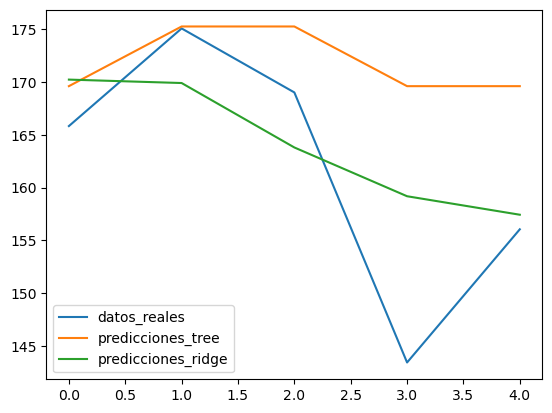

In [134]:
datos.plot()

In [145]:
final_forecaster_ridge = ForecasterAutoreg(
    regressor=Ridge(
        alpha=0.01,
        fit_intercept=False,
        solver="sparse_cg",
        random_state=42
    ),
    lags=9
)
final_forecaster_ridge.fit(y=df.Total)
steps = 9
preds = final_forecaster_ridge.predict(steps=steps)
preds.index = index=list(range(2022,2031))
preds.index.name = "Year"
preds.name = "Total"
preds

Year
2022    152.768059
2023    146.863583
2024    143.221456
2025    146.173887
2026    149.505415
2027    142.948713
2028    138.677758
2029    141.785196
2030    138.073167
Name: Total, dtype: float64

In [142]:
with open("co2_preds.pkl", "wb") as model:
    pickle.dump(final_forecaster_ridge, model)

In [146]:
preds.to_csv("co2_predicciones.csv")